In [ ]:
from torchvision.datasets import GTSRB
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
import json
from  tqdm import tqdm
import torch.nn as nn
import pandas as pd
from torch.utils.data import random_split
import torch.nn.functional as F

In [21]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
DEVICE = torch.device("mps")
n_classes = 43

In [22]:
transform = transforms.Compose([
    transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [23]:
train_dataset = GTSRB(root='../data', split='train', download=True, transform=transform)
test_dataset = GTSRB(root='../data', split='test', download=True, transform=transform)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
with open('../data/model/labels/classes_name.json', 'r') as file:
    classes_names = json.load(file)

In [27]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для нормализированных тензоров"""
    inp = inp.numpy().transpose((1,2,0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Денормализация
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

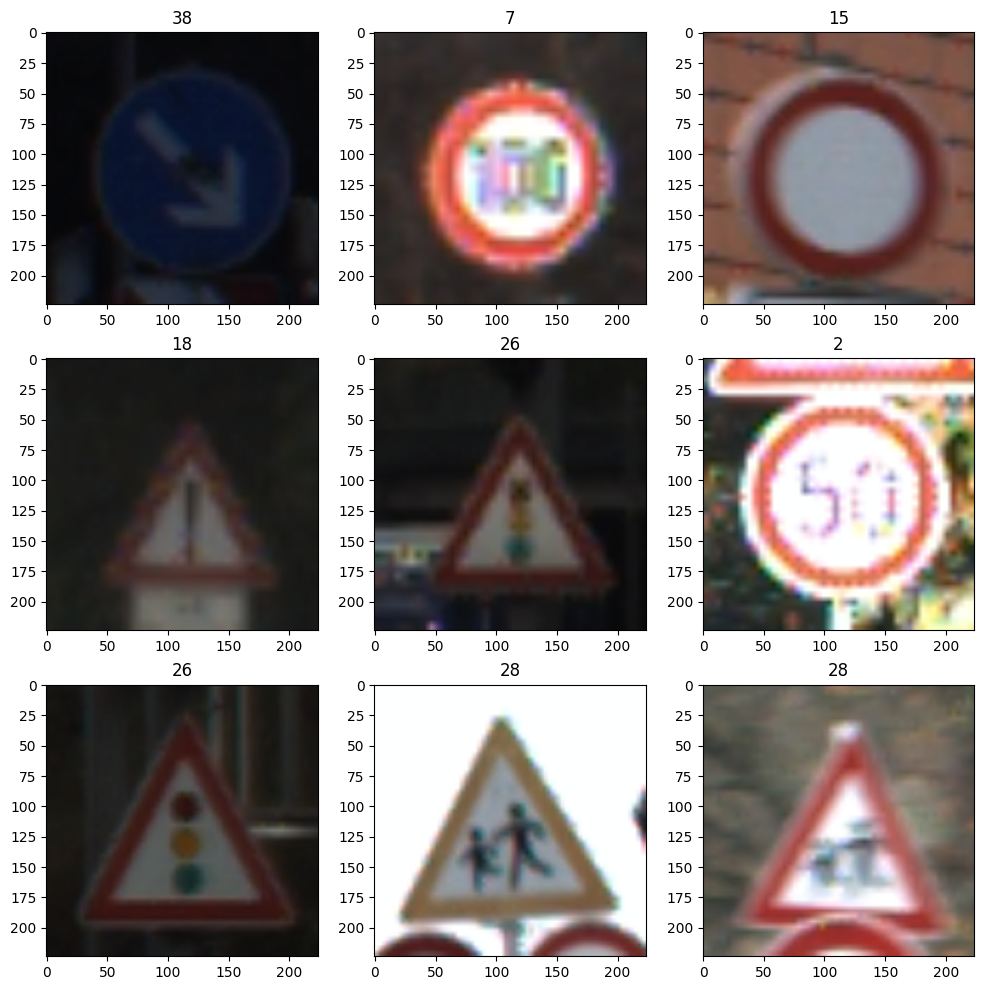

In [28]:
inputs, classes = next(iter(train_loader))

fig, ax = plt.subplots(3, 3, figsize=(12, 12))

imgs_idx = np.random.randint(1, 100, 9)
row = 1

for i in range(9):
    img = inputs[i]
    label = classes[i].item()
    # ax[i % 3][row - 1].imshow(img)
    # ax[i % 3][row - 1].set_title(classes_names[str(label)])
    imshow(img, title=str(label), plt_ax=ax[i % 3][row - 1])
    if (i + 1) % 3 == 0: row+=1


In [33]:
def train(train_dataset, val_dataset, model, epochs, batch_size,
          optimiser, criterion):
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=batch_size)

      history = []
      log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} " \
      "val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

      with tqdm(desc="epoch", total=epochs) as pbar_outer:
            opt = optimiser
            criterion = criterion
            # scheduler = ReduceLROnPlateau(opt, 'min')

            for epoch in range(epochs):
                  train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
                  print("loss", train_loss)

                  val_loss, val_acc = eval_epoch(model, val_loader, criterion)
                  history.append((train_loss, train_acc, val_loss, val_acc))

                  # scheduler.step(val_loss)

                  pbar_outer.update(1)
                  tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, \
                                                 v_loss=val_loss,
                                                 t_acc=train_acc, v_acc=val_acc))

      return history

def fit_epoch(model, train_loader, criterion, optimizer):
      running_loss = 0.0
      running_corrects = 0
      processed_data = 0

      for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)

      train_loss = running_loss / processed_data
      train_acc = running_corrects.cpu().numpy() / processed_data

      return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
      model.eval()
      running_loss = 0.0
      running_corrects = 0
      processed_size = 0

      for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.set_grad_enabled(False):
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  preds = torch.argmax(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds==labels.data)
            processed_size += inputs.size(0)
      val_loss = running_loss / processed_size
      val_acc =running_corrects.float() / processed_size
      return val_loss, val_acc


def predict(model, test_loader, device='mps'):
      model.eval()
      model.to(device)
      all_probs = []

      with torch.no_grad():
            for inputs, _ in test_loader:
                  inputs = inputs.to(device)

                  outputs = model(inputs)
                  probs = F.softmax(outputs, dim=1)
                  all_probs.append(probs.cpu())
      all_probs = torch.cat(all_probs, dim=0)

      predicted_classes = torch.argmax(all_probs, dim=1)

      return predicted_classes



In [34]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [35]:
import torchvision.models as models
from torchvision.models import ResNet34_Weights, resnet34

model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, n_classes)

for name, param in model.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False



In [36]:
resnet34 = model.to(DEVICE)

optimiser = torch.optim.Adam(resnet34.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
history = train(train_data, val_data, model=resnet34, epochs=5, batch_size=128,
                optimiser=optimiser, criterion=criterion)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.3449667488132511


epoch:  20%|██        | 1/5 [02:39<10:39, 159.98s/it]


Epoch 001 train_loss: 0.3450 val_loss 0.1210 train_acc 0.9044 val_acc 0.9636
loss 1.1375241446512956


epoch:  40%|████      | 2/5 [05:18<07:57, 159.33s/it]


Epoch 002 train_loss: 1.1375 val_loss 0.3251 train_acc 0.6935 val_acc 0.8994
loss 0.12836926378443972


epoch:  60%|██████    | 3/5 [08:06<05:26, 163.06s/it]


Epoch 003 train_loss: 0.1284 val_loss 0.1109 train_acc 0.9603 val_acc 0.9643
loss 0.048165827515526664


epoch:  80%|████████  | 4/5 [10:41<02:39, 159.85s/it]


Epoch 004 train_loss: 0.0482 val_loss 0.0663 train_acc 0.9854 val_acc 0.9777
loss 0.05128607584174734


epoch: 100%|██████████| 5/5 [13:15<00:00, 159.06s/it]


Epoch 005 train_loss: 0.0513 val_loss 0.0521 train_acc 0.9848 val_acc 0.9840


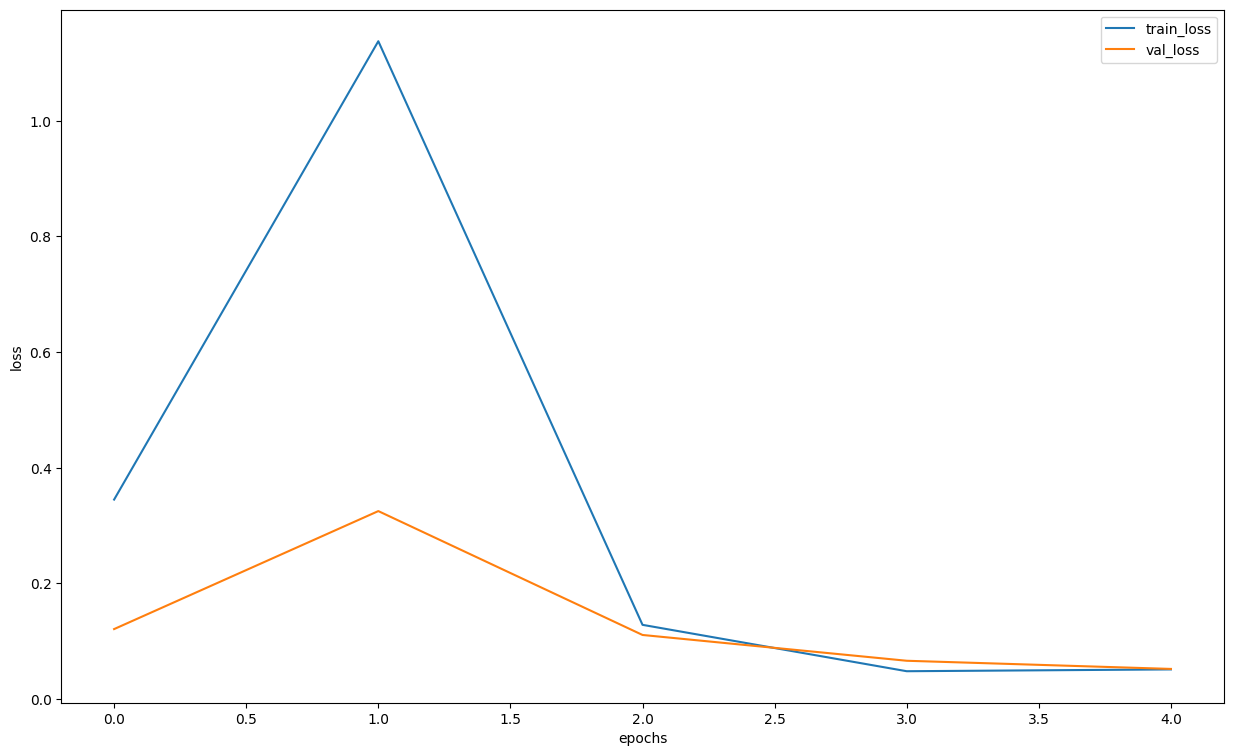

In [37]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [38]:
torch.save(resnet34.state_dict(), "model_weights.pth")

In [ ]:
resnet34.load_state_dict(torch.load('./model_weights.pth', map_location='mps'))
resnet34.eval()

In [ ]:
final_test = pd.read_csv('../data/gtsrb/GT-final_test.csv', sep=';')
final_labels = final_test.ClassId
final_labels[:5]

[ 1 78 63 58 30 37 48 37 66]


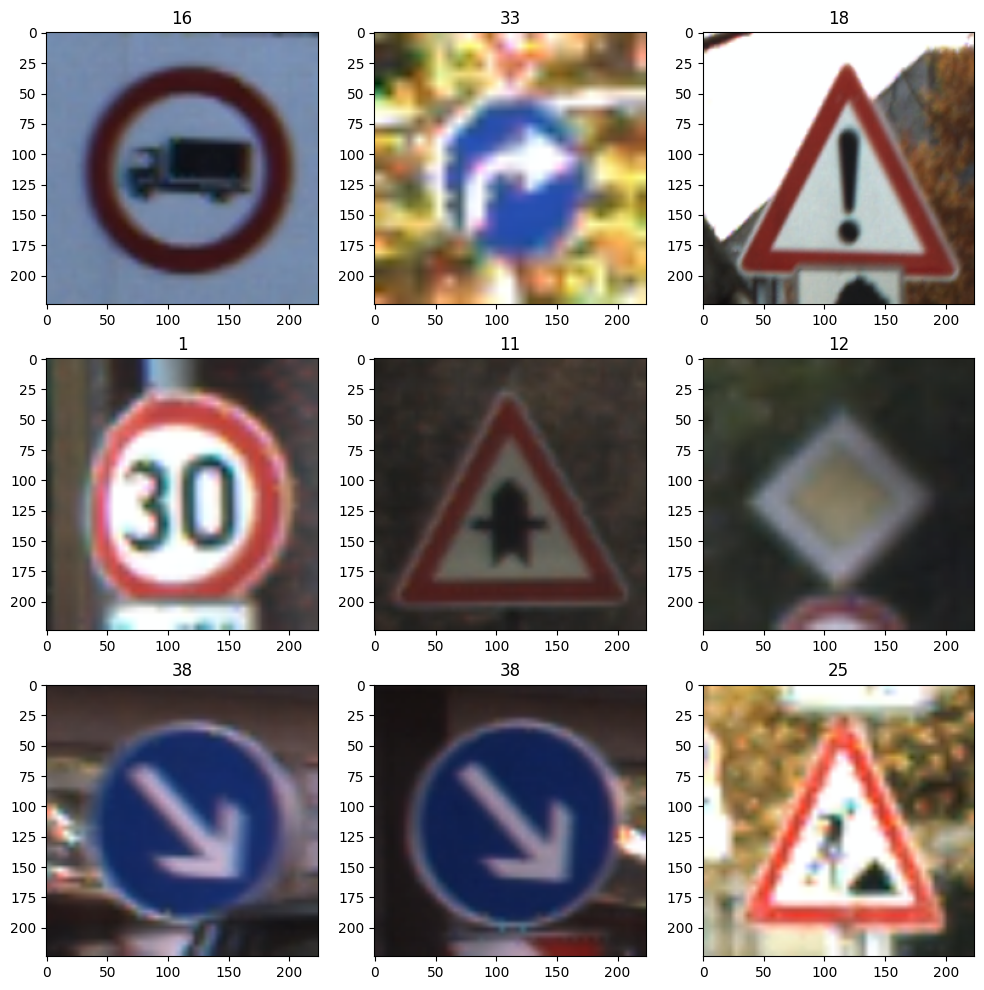

In [41]:
import torchvision.transforms.functional as Fu
inputs, classes = next(iter(test_loader))

fig, ax = plt.subplots(3, 3, figsize=(12, 12))

imgs_idx = np.random.randint(1, 100, 9)
print(imgs_idx)
row = 1

for i in range(9):
    img = inputs[i]
    label = classes[i].item()
    # ax[i % 3][row - 1].imshow(img)
    # ax[i % 3][row - 1].set_title(classes_names[str(label)])
    imshow(img, title=str(label), plt_ax=ax[i % 3][row - 1])
    if (i + 1) % 3 == 0: row+=1


In [42]:
preds = predict(resnet34,test_loader, device="mps")

In [43]:
preds

tensor([16,  1, 38,  ...,  6,  7, 10])

In [44]:
from sklearn.metrics import accuracy_score, f1_score

score = accuracy_score(final_labels, preds)
score

0.9296120348376881

In [45]:
f_1 = f1_score(final_labels, preds, average='weighted')

In [46]:
f_1

0.9296744179266303

In [49]:
example_input = torch.rand(1, 3, 224, 224).to(DEVICE)
torch.onnx.export(resnet34, 
                  example_input, 
                  '../data/model/resnet34_gtsrb.onnx',
                  input_names=["input"],
                  output_names=["output"],
                  opset_version=11,
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
                  )